# Step 1 - Clone the Github repo

In [1]:
# !rm -rf sonic-mood # force remove the cloned repo if it already exists (this ensures we always clone successfully and can get the latest code)
# !git clone https://github.com/Electronic-Yoda/sonic-mood.git

'rm' is not recognized as an internal or external command,
operable program or batch file.


Cloning into 'sonic-mood'...


You should see the repository cloned into sonic-mood directory. 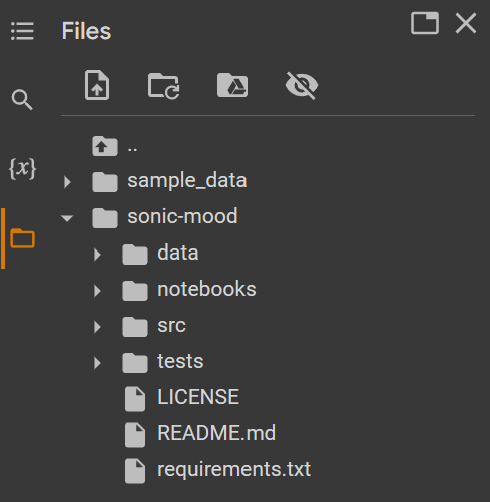

# Step 2 - add the GITHUB_REPO_PATH to Colab's Python path so we can import necessary modules.

In [1]:
GITHUB_REPO_PATH = 'sonic-mood'

import sys, os
# sys.path.insert(0, GITHUB_REPO_PATH)

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, BASE_DIR)

After this is done, you can import every python module in sonic-mood

In [2]:
from src.utils.dataset import MelspecEmotionDataset
from src.utils.constants import Columns, Emotions, Datasets
import src.utils.data_processing as data_processing

# Step 3 - Using datasets

In [3]:
# import google drive so we have access to the raw audio data stored there
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# APS360_DRIVE_PATH = '/content/gdrive/MyDrive/APS360 Project Group/'


In [3]:
import pandas as pd
import torch


# Copy the data to the drive
# !unzip '/content/gdrive/MyDrive/APS360 Project Group/data.zip' -d '/root/datasets'


# import csvs used for training, validation, and testing
train_df = data_processing.read_csv(
    pd.read_csv(
        os.path.join(BASE_DIR, 'data/metadata/train_melspec.csv'),
        index_col=False
    ),
    # '/root/datasets'
    BASE_DIR
)
val_df = data_processing.read_csv(
    pd.read_csv(
        os.path.join(BASE_DIR, 'data/metadata/val_melspec.csv'),
        index_col=False
    ),
    # '/root/datasets'
    BASE_DIR
)
test_df = data_processing.read_csv(
    pd.read_csv(
        os.path.join(BASE_DIR, 'data/metadata/test_melspec.csv'),
        index_col=False
    ),
    # '/root/datasets'
    BASE_DIR
)


In [4]:
# Create datasets.
# Note, there are additional optional arguments you can pass in. These arguments can be adjusted during training to see if better performance can be achieved. See MelspecEmotionDataset for more information.
train_ds = MelspecEmotionDataset(train_df)
val_ds = MelspecEmotionDataset(val_df)
test_ds = MelspecEmotionDataset(test_df)


# Create dataloaders
batch_size = 16
workers = 8
pin_memory = True if torch.cuda.is_available() else False
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, num_workers=workers, shuffle=True, pin_memory=pin_memory)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=workers, shuffle=True, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=workers, shuffle=True, pin_memory=pin_memory)

In [5]:
mini_train = torch.utils.data.Subset(train_ds,list(range(0, len(train_ds), 16)))
mini_train_loader = torch.utils.data.DataLoader(mini_train, batch_size=batch_size, num_workers=2, shuffle=True)

mini_val = torch.utils.data.Subset(val_ds,list(range(0, len(val_ds), 16)))
mini_val_loader = torch.utils.data.DataLoader(mini_val, batch_size=batch_size, num_workers=2, shuffle=True)

mini_test = torch.utils.data.Subset(train_ds,list(range(0, len(test_ds), 16)))
mini_test_loader = torch.utils.data.DataLoader(mini_test, batch_size=batch_size, num_workers=2, shuffle=True)

In [6]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

print(len(mini_train_loader))
print(len(mini_val_loader))
print(len(mini_test_loader))

532
114
115
34
8
8


In [19]:
import torch.nn as nn
import torch.nn.functional as F
import math

import torch.optim as optim
import numpy as np
import time

class AudioCNN(nn.Module):
    def __init__(self, kernel_dimensions = [5, 2], stride_sizes = [1, 1], padding_sizes = [1, 1]):
        super().__init__()
        self.name = 'AudioCNN'

        input_dimension_x = 64
        input_dimension_y = 292
        pool_kernel_dimension = 2
        pool_stride_size = 2

        self.conv1 = nn.Conv2d(1, 6, kernel_dimensions[0], stride=stride_sizes[0], padding=padding_sizes[0])
        self.conv2 = nn.Conv2d(6, 12,  kernel_dimensions[1], stride=stride_sizes[1], padding=padding_sizes[1])
        self.pool = nn.MaxPool2d(2, 2)

        a_x = math.floor((input_dimension_x + 2 * padding_sizes[0]- kernel_dimensions[0]) / stride_sizes[0] + 1)
        b_x = math.floor((a_x - pool_kernel_dimension) / pool_stride_size + 1)
        c_x = math.floor((b_x + 2 * padding_sizes[1] - kernel_dimensions[1]) / stride_sizes[1] + 1)
        d_x = math.floor((c_x - pool_kernel_dimension) / pool_stride_size + 1)

        a_y = math.floor((input_dimension_y + 2 * padding_sizes[0]- kernel_dimensions[0]) / stride_sizes[0] + 1)
        b_y = math.floor((a_y - pool_kernel_dimension) / pool_stride_size + 1)
        c_y = math.floor((b_y + 2 * padding_sizes[1] - kernel_dimensions[1]) / stride_sizes[1] + 1)
        d_y = math.floor((c_y - pool_kernel_dimension) / pool_stride_size + 1)
        self.fc_input_size = 12 * d_x * d_y

        self.fc1 = nn.Linear(self.fc_input_size, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 8)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # print(self.fc_input_size)
        x = x.view(-1, self.fc_input_size)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
import matplotlib.pyplot as plt

def train_net(net, train_loader, val_loader, batch_size=32, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Loss fn and Optimizer
    criterion = nn.CrossEntropyLoss() # CE, for k classes (in this case k = 8)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate) # Adam optimizer
    ########################################################################
    # Training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Training
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset num_epochs times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0

        for i, data in enumerate(train_loader, 0):
            # print("Loader",i)
            inputs, labels = data # Get the inputs
            if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
            optimizer.zero_grad() # Zero the parameter gradients
            outputs = net(inputs) # forwards
            loss = criterion(outputs, labels) # compute loss
            loss.backward() # backwards
            optimizer.step() # optimizer
            total_train_loss += loss.item()

        train_err[epoch] = get_error(net, train_loader)
        train_loss[epoch] = float(total_train_loss) / (len(train_loader))
        val_err[epoch] = get_error(net, val_loader)
        val_loss[epoch] = get_loss(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


##########################################
# Evaluation Functions

def get_error(model, data_loader):
    correct = 0
    total = 0
    eval_mod = model.eval()
    for inputs, labels in data_loader:
        if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
        out = eval_mod(inputs)
        #select index with maximum prediction score
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inputs.shape[0]
    return (total-correct) / total

def get_loss(model, data_loader, criterion):
    loss = 0.0
    total_loss = 0.0
    eval_mod = model.eval()
    for inputs, labels in data_loader:
      if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
      out = eval_mod(inputs)
      loss = criterion(out, labels)
      total_loss += loss.item()

    loss = float(total_loss) / (len(data_loader))
    return loss


########################################################################
# Helper fns from lab 2
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        for data_i,datapoint in enumerate(outputs):
              pred = torch.argmax(datapoint)
              # print(pred)
              # print(labels[data_i])
              if pred != labels[data_i]:
                # print("Wrong pred!")
                total_err += 1
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [20]:
net = AudioCNN()
if torch.cuda.is_available():
  print("CUDA AVAILABLE")
  net.cuda()
train_net(net, train_loader, val_loader, batch_size=16, learning_rate=0.001,num_epochs=20)

CUDA AVAILABLE
Epoch 1: Train err: 0.3812265037593985, Train loss: 1.7187660217733312 |Validation err: 0.4267690619857378, Validation loss: 1.138130315563135
Epoch 2: Train err: 0.28829887218045114, Train loss: 1.0151036350910825 |Validation err: 0.41579813494240264, Validation loss: 1.0738407687137002
Epoch 3: Train err: 0.21980733082706766, Train loss: 0.8039901844765011 |Validation err: 0.4004388370817334, Validation loss: 1.0818358842740978
Epoch 4: Train err: 0.11607142857142858, Train loss: 0.5859900947688217 |Validation err: 0.38069116840373013, Validation loss: 1.1258229255153422
Epoch 5: Train err: 0.07906484962406016, Train loss: 0.3817315851128135 |Validation err: 0.41799232035106965, Validation loss: 1.4222421549391329
Epoch 6: Train err: 0.051456766917293235, Train loss: 0.22499093636730336 |Validation err: 0.41415249588590236, Validation loss: 1.801739206962418
Epoch 7: Train err: 0.043233082706766915, Train loss: 0.14082109748037475 |Validation err: 0.41579813494240264, 

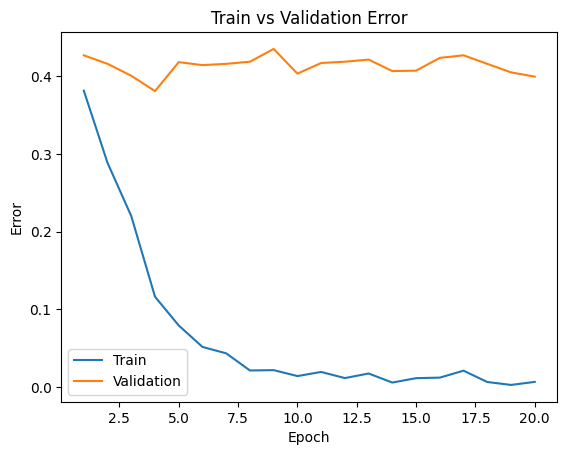

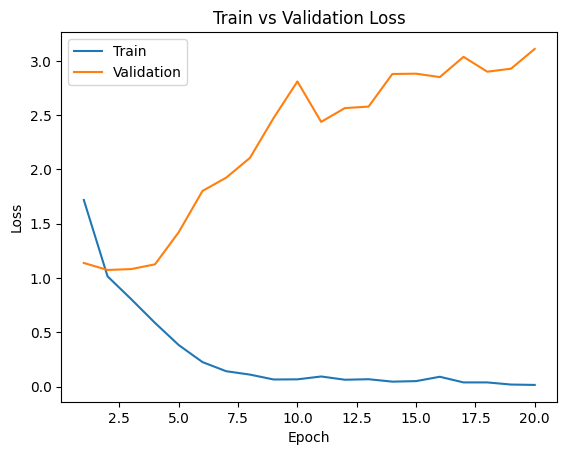

In [21]:
model_path = get_model_name("AudioCNN", batch_size=16, learning_rate=0.001, epoch=19)
plot_training_curve(model_path)

Initial iteration: 20 epochs, lr 0.001, batch size 16, mini train + mini val loaders
Iteration 1: 30 epochs, lr 0.001, batch size 16, train + val loaders
Iteration 2: 20 epochs, lr 0.001, batch size 16, train + val loaders (TRY NEW ARCHITECTURE; reduce pooling 4,4 -> 2,2, hidden layer 500 -> 100)
Iteration 3: 20 epochs, lr 0.001, batch size 16, train + val loaders (TRY NEW ARCHITECTURE; additional fc lin layer for more params to train) **LATEST/BEST MODEL

# Dimensions
The dimensions of your inputs will be (batch size, number of channels, number of Mel frequency bands, number of frames over time), i.e., (N, C, n_mels, T). For Mel-spectrogram, number of channels is just 1.

The dimension of the labels is just (batch size). Each element of the tensor is an integer representing a specific emotion. The integer ranges from 0 to 7. See the example below if you want to convert the integer into its string representation.

In [ ]:
# Note, we can convert labels from integers to strings using Emotions().from_index(emotion_int)
from src.utils.constants import Emotions

# say we have a list of emotions integers from 0 to 7
emotions_integers = [0, 1, 2, 3, 4, 5, 6, 7]
emotions_strings = []
for emotion_int in emotions_integers:
    emotions_strings.append(Emotions().from_index(emotion_int))

print(emotions_integers)
print(emotions_strings)

[0, 1, 2, 3, 4, 5, 6, 7]
['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
